# exp052
word2vec rank追加

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [2]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "exp052"
    seed = 42
    k = 20
    cand_n = 15
    negative_sample = 1
    train_chunk_n = 1
    test_chunk_n = 1
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

    clicks_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 5.485903737168179, 'lambda_l2': 0.005594683492536064, 'num_leaves': 79, 'feature_fraction': 0.552, 'bagging_fraction': 0.9295272232672004, 'bagging_freq': 2, 'min_child_samples': 10}
    carts_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 8.709050252544463, 'lambda_l2': 0.06935262036337767, 'num_leaves': 252, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
    orders_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 9.356310279757256, 'lambda_l2': 1.3120983078968551e-08, 'num_leaves': 174, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [3]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*.pkl"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, filename))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        return len([str(c) for c in self.caches if path == str(c)]) > 0


cache = Cache()

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.60
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [6]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels
    
    @noglobal(excepts=["cfg", "logger"])
    def _entry(self, new_candidate_df, name, k):
        logger.info(f"[add_candidate] {name} : start")
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid"]]])
        self.output = self.output.drop_duplicates(subset=["session", "aid"])

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)
    
    @noglobal(excepts=["cfg", "logger"])
    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        print(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[make_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [7]:
@noglobal(excepts=["cfg", "logger"])
def add_labels(df, labels, type_):
    type_labels = labels[["session", f"{type_}_labels"]].dropna().copy()
    type_labels.columns = ["session", "aid"]
    type_labels = type_labels.explode("aid")
    type_labels["labels"] = 1
    df = df.merge(type_labels, on=["session", "aid"], how="left")
    df["labels"] = df["labels"].fillna(0)
    return df    

In [8]:
@noglobal(excepts=["cfg", "logger"])
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [9]:
@noglobal(excepts=["cfg", "logger"])
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df[df[label_col]==1].copy()
    neg_df = df[df[label_col]==0].copy()
    pos_n = len(pos_df)
    return pd.concat([pos_df, neg_df.sample(pos_n * cfg.negative_sample, random_state=cfg.seed)])

In [ ]:
class Features:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, sessions, candidate, week):
        self.sessions = cudf.from_pandas(sessions)
        self.output = candidate
        self.type_dict = cfg.type2id
        self.week = week
        self.latest_aid_n = 5

    @noglobal(excepts=["cfg", "logger"])
    def add_features(self):
        # self._prep()
        self._session_cnt()
        self._session_aid_nunique()
        self._session_last_type()
        self._aid_cnt()
        self._all_times_aid_features()
        self._w2v_vectors()
        self._relative_ts()
        self._add_aid_latest()
        self._co_visit_rank("co_visitation_matrix")
        self._co_visit_rank("co_visitation_matrix_time_weighted", "wt")
        self._co_visit_rank("co_visitation_matrix_type_weighted", "wt")
        self._co_visit_rank("co_visitation_matrix_clicks2carts")
        self._co_visit_rank("co_visitation_matrix_clicks2orders")
        self._latest_aid_w2v_sims()
        self._drop_aid_latest()
        # self._session_mean_ts()
        # self._aid_mean_ts()
        # self._aid_cnt_ratio_at_session_last()
        # self.output = self.output.drop(columns=["session_last_day"]) # 日時はtrainセット内のみで有効なので削除

    @noglobal(excepts=["cfg", "logger"])
    def _prep(self):
        logger.info("[features] prep : start")
        # ts関連の前処理
        self.sessions["relative_ts"] = self.sessions["ts"] - self.sessions["ts"].min()
        self.sessions["dt"] = cudf.to_datetime(self.sessions["ts"], unit="ms")
        self.sessions["hour"] = self.sessions["dt"].dt.hour
        self.sessions["week"] = self.sessions["dt"].dt.dayofweek
        self.sessions["day"] = self.sessions["dt"].dt.day
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_cnt(self):
        logger.info("[features] session_cnt : start")
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_total_cnt"] = self.output["session_total_cnt"].fillna(0)
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_aid_nunique(self):
        logger.info("[features] session_aid_nunique : start")
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_aid_nunique"] = self.output["session_aid_nunique"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_type(self):
        logger.info("[features] session_last_type : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_dt(self):
        logger.info("[features] session_last_dt : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "relative_ts", "week", "day", "hour"]]
        features.columns = ["session", "session_last_ts", "session_last_week", "session_last_day", "session_last_hour"]
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_mean_ts(self):
        logger.info("[features] session_mean_ts : start")
        features = self.sessions.groupby("session")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "session_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_mean_ts(self):
        logger.info("[features] aid_mean_ts : start")
        features = self.sessions.groupby("aid")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "aid_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")
       
    @noglobal(excepts=["cfg", "logger"])
    def _aid_session_nunique(self):
        logger.info("[features] aid_session_unique : start")
        features = self.sessions.groupby("aid")["session"].nunique().reset_index().rename(columns={"session": "aid_session_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")

    @noglobal(excepts=["cfg", "logger"]) 
    def _aid_cnt_ratio_at_session_last(self):
        logger.info("[features] aid_cnt_ratio_atsession_last : start")
        for dt_ in ["week", "day", "hour"]:
            features = self.sessions[["aid", dt_]].copy()
            features["total_cnt"] = features.groupby(dt_)["aid"].transform("count")
            features = features.groupby(["aid", dt_])["total_cnt"].agg(["count", "max"]).reset_index()
            features[f"aid_cnt_ratio_at_session_last_{dt_}"] = features["count"] / features["max"]
            features = features.rename(columns={dt_: f"session_last_{dt_}"})
            self.output = self.output.merge(features[["aid", f"session_last_{dt_}", f"aid_cnt_ratio_at_session_last_{dt_}"]].to_pandas(), on=["aid", f"session_last_{dt_}"], how="left")
            self.output[f"aid_cnt_ratio_at_session_last_{dt_}"] = self.output[f"aid_cnt_ratio_at_session_last_{dt_}"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_cnt(self):
        logger.info("[features] aid_cnt : start")
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
        self.output["aid_total_cnt"] = self.output["aid_total_cnt"].fillna(0)

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)

    @noglobal(excepts=["cfg", "logger"])
    def _all_times_aid_features(self):
        feats = ["all_times_aid_freq",
                 "all_times_aid_clicks_freq",
                 "all_times_aid_carts_freq",
                 "all_times_aid_orders_freq",
                 "all_times_aid_session_freq",
                 "all_times_aid_session_clicks_freq",
                 "all_times_aid_session_carts_freq",
                 "all_times_aid_session_orders_freq",
                 "all_times_aid_carts_ratio_with_clicks",
                 "all_times_aid_orders_ratio_with_clicks",
                 "all_times_aid_date_std",
                 "all_times_aid_hour_std",
                 "all_times_aid_day_of_week_std"]
        
        for feat in feats:
            if self.week is None:
                with open(cfg.prep_dir + f"{feat}.pkl", "rb") as f:
                    feat_map = pickle.load(f)
            else:
                with open(cfg.prep_dir + f"{feat}_{self.week}.pkl", "rb") as f:
                    feat_map = pickle.load(f)
            self.output[feat] = self.output["aid"].map(feat_map)

    @noglobal(excepts=["cfg", "logger"])
    def _w2v_vectors(self):
        w2v_vecs = pd.read_pickle(cfg.prep_dir + "w2v_vector_n5.pkl")
        self.output = self.output.merge(w2v_vecs, on="aid", how="left")

    @noglobal(excepts=["cfg", "logger"])
    def _relative_ts(self):
        features = self.sessions.sort_values(["session", "ts"]).drop_duplicates(subset=["session", "aid"], keep="last")
        features["relative_ts_in_session"] = features.groupby("session")["ts"].transform("max") - features["ts"]
        features = features.sort_values(["session", "ts"], ascending=(True, False)).reset_index(drop=True)
        features["ts_rank_in_session"] = features.groupby("session").cumcount()
        features = features[["session", "aid", "relative_ts_in_session", "ts_rank_in_session"]]
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")

    @noglobal(excepts=["cfg", "logger"])
    def _add_aid_latest(self):
        sorted_df = self.sessions.sort_values(["session", "ts"], ascending=(True, False), ignore_index=True)
        for i in range(self.latest_aid_n):
            latest_aid = sorted_df.groupby("session").nth(i)["aid"].to_pandas().to_dict()
            self.output[f"aid_latest{i}"] = self.output["session"].map(latest_aid)
            self.output[f"aid_latest{i}"] = self.output[f"aid_latest{i}"].fillna(-1).astype("int32")
    
    @noglobal(excepts=["cfg", "logger"])
    def _drop_aid_latest(self):
        drop_cols = [f"aid_latest{str(i)}" for i in range(self.latest_aid_n)]
        self.output = self.output.drop(columns=drop_cols)

    @noglobal(excepts=["cfg", "logger"])
    def _co_visit_rank(self, co_visit_name, wt_col="cnt"):
        if self.week is None:
            co_visit_df = pd.read_pickle(cfg.prep_dir + f"{co_visit_name}.pkl")
        else:
            co_visit_df = pd.read_pickle(cfg.prep_dir + f"{co_visit_name}_{self.week}.pkl")
        co_visit_df = co_visit_df.sort_values(["aid_x", wt_col], ascending=(True, False), ignore_index=True)
        co_visit_df[f"rank"] = co_visit_df.groupby(["aid_x"]).cumcount()

        for i in range(self.latest_aid_n):
            self.output = self.output.merge(co_visit_df[["aid_x", "aid_y", "rank"]], left_on=[f"aid_latest{i}", "aid"], right_on=["aid_x", "aid_y"], how="left")
            self.output["rank"] = self.output["rank"].fillna(-1).astype("int32")
            self.output = self.output.rename(columns={"rank": f"{co_visit_name}_lt{i}"})
            self.output = self.output.drop(columns=["aid_x", "aid_y"])

    @noglobal(excepts=["cfg", "logger"])
    def _latest_aid_w2v_sims(self, vec_n=20):
        w2v_vecs = pd.read_pickle(cfg.prep_dir + f"w2v_vector_n{vec_n}.pkl")
        w2v_cols = [f"w2v_{i}" for i in range(vec_n)]
        w2v_dict = {aid:vecs for aid, vecs in zip(w2v_vecs["aid"].tolist(), w2v_vecs[w2v_cols].values)}

        for i in range(self.latest_aid_n):
            sims = []
            for aid, latest_aid in zip(self.output["aid"].tolist(), self.output[f"aid_latest{i}"].tolist()):
                if latest_aid == -1:
                    sims.append(-1)
                else:
                    aid_vecs = w2v_dict[aid]
                    latest_aid_vecs = w2v_dict[latest_aid]
                    sim = np.dot(aid_vecs, latest_aid_vecs) / (np.linalg.norm(aid_vecs)*np.linalg.norm(latest_aid_vecs))
                    sims.append(np.float16(sim))
            self.output[f"w2v_sim_lt{i}"] = sims
        

In [11]:
@noglobal(excepts=["cfg", "logger"])
def add_features(sessions, cand_df, week=None):
    feat = Features(sessions, cand_df, week)
    feat.add_features()
    return feat.output

In [12]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, labels=None, trans_maps=None):

    if labels is not None:
         cand = Candidate(sessions, labels)
    else:
        cand = Candidate(sessions)

    cand.add(strategy="session_frequent", name="session_frequent", k=15)
    cand.add(strategy="session_latest", name="session_latest", k=15)
    
    for i in range(20):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"time_wt_pair{str(i)}"], name=f"session_latest_time_wt_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"word2vec_pair{str(i)}"], name=f"session_latest_word2vec_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}", k=5)
    for i in range(5):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"type_wt_pair{str(i)}"], name=f"session_latest_type_wt_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"clicks2carts_pair{str(i)}"], name=f"session_latest_clicks2carts_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"clicks2orders_pair{str(i)}"], name=f"session_latest_clicks2orders_pair{str(i)}", k=5)
        

    if labels is not None:
        return cand.output, cand.results
    else:
        return cand.output

In [13]:
@noglobal(excepts=["cfg", "logger"])
def get_pair_df(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    return pair_df

@noglobal(excepts=["cfg", "logger"])
def get_pair_dict(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    return pair_dict

@noglobal(excepts=["cfg", "logger"])
def get_trans_maps(week=None):
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}
    
    pair_df_org = get_pair_df("co_visitation_matrix", "cnt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"pair{str(i)}"] = pair_dict
    
    pair_df_org = get_pair_df("co_visitation_matrix_time_weighted", "wt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"time_wt_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_type_weighted", "wt", week)
    for i in range(5):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"type_wt_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_clicks2carts", "cnt", week)
    for i in range(5):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"clicks2carts_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_clicks2orders", "cnt", week)
    for i in range(5):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"clicks2orders_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("word2vec_similar", "sim", None)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"word2vec_pair{str(i)}"] = pair_dict

    return trans_maps

In [14]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_train_data(type_):
    dfs = []
    for weeks in cfg.train_weeks:
        # データ読み込み
        week_sessions = pd.read_pickle(cfg.prep_dir + f"train_sessions_{weeks}.pkl")
        week_labels = pd.read_pickle(cfg.prep_dir + f"labels_{weeks}.pkl")
        sessions_lists = np.array_split(week_sessions["session"].unique().tolist(), cfg.train_chunk_n)

        # cand作成
        for chunk in range(cfg.train_chunk_n):
            cache_file = f"train_cand_{weeks}_{chunk}.pkl"
            cache_path = cache.get_abspath(cache_file)
            print(cache_path)
            if cache.exists(cache_path):
                logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
                cand_df = pd.read_pickle(cache_path)
            else:
                trans_map_cache_file = f"trans_maps_{weeks}.pkl"
                trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
                with open(trans_map_cache_path, "rb") as f:
                    trans_maps = pickle.load(f)
                # 候補選出
                week_sessions_chunk = week_sessions[week_sessions["session"].isin(sessions_lists[chunk])].reset_index(drop=True)
                cand_df = make_cand_df(week_sessions_chunk, trans_maps=trans_maps)
                cand_df = reduce_mem_usage(cand_df)
                cand_df.to_pickle(cache_path)
                del week_sessions_chunk
                gc.collect()

        # candラベル付け・サンプリング
        cand_dfs = []
        for chunk in range(cfg.train_chunk_n):
            cache_file = f"train_cand_{weeks}_{chunk}.pkl"
            cache_path = cache.get_abspath(cache_file)
            cand_df_chunk = pd.read_pickle(cache_path)
            week_labels_chunk = week_labels[week_labels["session"].isin(sessions_lists[chunk])].reset_index(drop=True)
            cand_df_chunk = add_labels(cand_df_chunk, week_labels_chunk, type_)
            cand_df_chunk = under_sampling(cand_df_chunk, "labels")
            cand_dfs.append(cand_df_chunk)
            del cand_df_chunk, week_labels_chunk
            gc.collect()
        cand_df = pd.concat(cand_dfs)
        del cand_dfs
        gc.collect()

        # データ確認
        pos_cnt = len(cand_df[cand_df["labels"]==1])
        neg_cnt = len(cand_df[cand_df["labels"]==0])
        logger.info(f"train({type_}) pos : {str(pos_cnt)}  neg : {str(neg_cnt)}")

        # 特徴量付与
        train_tmp = add_features(week_sessions, cand_df, weeks)
        dfs.append(train_tmp)
        del cand_df, train_tmp
        gc.collect()
        
    train = pd.concat(dfs)
    train = train.reset_index(drop=True)
    train = reduce_mem_usage(train)

    # データ確認
    pos_cnt = len(train[train["labels"]==1])
    neg_cnt = len(train[train["labels"]==0])
    logger.info(f"train({type_}) pos : {str(pos_cnt)}  neg : {str(neg_cnt)}")

    return train

In [15]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_valid_cand():
    valid_week = cfg.valid_week
    # データ読み込み
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
    valid_session_ids = week_sessions["session"].unique().tolist()
    trans_map_cache_file = f"trans_maps_{valid_week}.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    # validに使うsessionを絞る
    valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
    random.seed(cfg.seed)
    valid_session_ids = random.sample(valid_session_ids, valid_session_n)
    week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
    week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()

    # 候補選出
    cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
    cand_df = reduce_mem_usage(cand_df)
    return cand_df, week_sessions, week_labels

In [16]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(cand_df, week_sessions, week_labels, type_):
    # 特徴量付与
    valid = add_features(week_sessions, cand_df, cfg.valid_week)
    valid = add_labels(valid, week_labels, type_)
    valid = valid.reset_index(drop=True)
    valid = reduce_mem_usage(valid)

    # データ確認
    pos_cnt = len(valid[valid["labels"]==1])
    neg_cnt = len(valid[valid["labels"]==0])
    logger.info(f"valid({type_}) pos : {str(pos_cnt)}  neg : {str(neg_cnt)}")
    
    return valid

In [17]:
@noglobal(excepts=["cfg", "logger"])
def model_training(train, valid, features, target, valid_labels, type_):
    if type_ == "clicks":
        params = cfg.clicks_params
    elif type_ == "carts":
        params = cfg.carts_params
    elif type_ == "orders":
        params = cfg.orders_params

    # 学習
    vl_pred_df = valid[["session", "aid"]].copy()

    tr_x, tr_y = train[features], train[target]
    vl_x, vl_y = valid[features], valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)

    # 特徴量重要度
    fi = pd.DataFrame()
    fi["feature"] = model.feature_name()
    fi["importance"] = model.feature_importance(importance_type="gain")

    # 2値分類の出力を元にk個選定
    vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
    vl_pred_df = vl_pred_df.sort_values(["session", "prob"], ascending=(True, False))
    vl_pred_df = vl_pred_df.groupby(["session"]).head(cfg.k)
    vl_pred_df = vl_pred_df.groupby(["session"])["aid"].apply(list).reset_index()
    
    # 評価
    assert valid_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
    score = evaluate(valid_labels["clicks_labels"].tolist(),
                     valid_labels["carts_labels"].tolist(),
                     valid_labels["orders_labels"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     cfg.k)
    logger.info(f"{type_} valid score")
    logger.info(score)

    # モデル保存
    model.save_model(cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

    # 特徴量重要度
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance({type_})")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance_{type_}.png')

    return score[f"recall_{type_}"]

In [18]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_test_data():
    # testデータ作成
    test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")
    sessions_lists = np.array_split(test_sessions["session"].unique().tolist(), cfg.test_chunk_n)
    trans_map_cache_file = f"trans_maps.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    for chunk in range(cfg.test_chunk_n):
        cache_file = f"test_{chunk}.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
        else:
            test_sessions_chunk = test_sessions[test_sessions["session"].isin(sessions_lists[chunk])].reset_index(drop=True)
        # 候補選出
        logger.info("[make_test] make_cand_df")
        cand_df = make_cand_df(test_sessions_chunk, trans_maps=trans_maps)
        cand_df = reduce_mem_usage(cand_df)
        # 特徴量付与
        logger.info("[make_test] add_features")
        test = add_features(test_sessions, cand_df)
        test = reduce_mem_usage(test)
        test.to_pickle(cache_path)        

In [19]:
@noglobal(excepts=["cfg", "logger", "cache"])
def inference(features):
    pred_dfs = []
    for chunk in range(cfg.test_chunk_n):
        cache_file = f"test_{chunk}.pkl"
        cache_path = cache.get_abspath(cache_file)
        test = pd.read_pickle(cache_path)

        for type_ in ["clicks", "carts", "orders"]:    
            pred_df_tmp = test[["session", "aid"]].copy()
            # 推論
            model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")
            # 2値分類の出力を元にk個選定
            pred_df_tmp["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
            pred_df_tmp = pred_df_tmp.sort_values(["session", "prob"], ascending=(True, False))
            pred_df_tmp = pred_df_tmp.groupby(["session"]).head(cfg.k)
            pred_df_tmp["aid"] = pred_df_tmp["aid"].astype(str)
            pred_df_tmp = pred_df_tmp.groupby(["session"])["aid"].apply(list).reset_index()
            pred_df_tmp["aid"] = pred_df_tmp["aid"].apply(lambda x: ' '.join(x))
            pred_df_tmp["type"] = type_
            pred_dfs.append(pred_df_tmp)
        del test, model
        gc.collect()
    
    pred_df = pd.concat(pred_dfs)
    # sub作成
    sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
    pred_df["session_type"] = pred_df["session"].astype(str) + "_" + pred_df["type"]
    pred_df = pred_df.rename(columns={"aid": "labels"})
    sub = sub.merge(pred_df[["session_type", "labels"]], on="session_type", how="left")
    sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)

In [20]:
@noglobal(excepts=["cfg", "logger", "cache"])
def main():
    scores = {}
    logger.info(f"START")
    line_notify.send(f"{cfg.exp_name} | START")
    
    # trans_map作成
    weeks = [None] + cfg.train_weeks + [cfg.valid_week]
    for week in weeks:
        if week is None:
            cache_file = "trans_maps.pkl"
        else:    
            cache_file = f"trans_maps_{week}.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. load cache and skip process.")
            with open(cache_path, "rb") as f:
                trans_maps = pickle.load(f)
        else:
            trans_maps = get_trans_maps(week)
            with open(cache_path, "wb") as f:
                pickle.dump(trans_maps, f)

    for type_ in ["clicks", "carts", "orders"]:
        # train data作成
        logger.info(f"make {type_}_train_data")
        cache_file = f"{type_}_train.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            train = pd.read_pickle(cache_path)
        else:
            train = make_train_data(type_)
            train.to_pickle(cache_path)
        
        logger.info(f"make {type_}_valid_data")
        # valid cand作成
        cand_cache_path = cache.get_abspath("valid_cand.pkl")
        sessions_cache_path = cache.get_abspath("valid_sessions.pkl")
        labels_cache_path = cache.get_abspath("valid_labels.pkl")
        if cache.exists(cand_cache_path) & cache.exists(labels_cache_path) & cache.exists(sessions_cache_path):
            logger.info("[valid_cand.pkl] cache exists. read cache and skip process.")
            valid_cand = pd.read_pickle(cand_cache_path)
            valid_sessions = pd.read_pickle(sessions_cache_path)
            valid_labels = pd.read_pickle(labels_cache_path)
        else:
            valid_cand, valid_sessions, valid_labels = make_valid_cand()
            valid_cand.to_pickle(cand_cache_path)
            valid_sessions.to_pickle(sessions_cache_path)
            valid_labels.to_pickle(labels_cache_path)

        # valid data作成
        logger.info(f"make {type_}_valid_data")
        cache_file = f"{type_}_valid.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            valid = pd.read_pickle(cache_path)
        else:
            valid = make_valid_data(valid_cand, valid_sessions, valid_labels, type_)
            valid.to_pickle(cache_path)

        # モデル学習
        target = "labels"
        not_use_cols = ["session", "aid", target]
        features = [c for c in train.columns if c not in not_use_cols]

        scores[f"recall_{type_}"] = model_training(train, valid, features, target, valid_labels, type_)

        del train, valid, valid_labels
        gc.collect()
    
    scores["total"] = (float(scores["recall_clicks"]) * 0.1) + (float(scores["recall_carts"]) * 0.3) + (float(scores["recall_orders"]) * 0.6)
    report = f"\n{cfg.exp_name}\n"
    report += f'valid_end\n'
    report += str(scores)
    line_notify.send(report)

    # testデータ
    make_test_data()

    logger.info(f"-------- inference --------")
    inference(features)

    line_notify.send(f"{cfg.exp_name} | END!!")

0:00:01.157722 	 START
0:00:05.527985 	 [trans_maps.pkl] cache exists. load cache and skip process.
0:00:19.226701 	 [trans_maps_week3.pkl] cache exists. load cache and skip process.
0:00:33.910867 	 [trans_maps_week4.pkl] cache exists. load cache and skip process.
0:00:49.386465 	 make clicks_train_data
0:00:56.186547 	 [train_cand_week3_0.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp052/cache/train_cand_week3_0.pkl


0:05:52.762841 	 train(clicks) pos : 2634664  neg : 2634664
0:05:56.271736 	 [features] session_cnt : start
0:06:04.100877 	 [features] session_aid_nunique : start
0:06:06.440623 	 [features] session_last_type : start
0:06:08.783982 	 [features] aid_cnt : start


Memory usage of dataframe is 1839.23 MB
Memory usage after optimization is: 738.71 MB
Decreased by 59.8%


1:07:19.854814 	 train(clicks) pos : 2634664  neg : 2634664
1:07:21.010406 	 make clicks_valid_data
1:07:21.011593 	 [valid_cand.pkl] cache exists. read cache and skip process.
1:07:21.622028 	 make clicks_valid_data
1:07:21.652345 	 [features] session_cnt : start
1:07:25.670601 	 [features] session_aid_nunique : start
1:07:26.634461 	 [features] session_last_type : start
1:07:27.661186 	 [features] aid_cnt : start


Memory usage of dataframe is 3246.02 MB
Memory usage after optimization is: 1285.99 MB
Decreased by 60.4%


2:11:54.104287 	 valid(clicks) pos : 56358  neg : 9243359
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 2634664, number of negative: 2634664
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.404643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13180
[LightGBM] [Info] Number of data points in the train set: 5269328, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.343703	valid_1's binary_logloss: 0.341089
[200]	training's binary_logloss: 0.340517	valid_1's binary_logloss: 0.339143
[300]	training's binary_logloss: 0.338732	valid_1's binary_logloss: 0.338541
[400]	training's binary_logloss: 0.337251	valid_1's binary_logloss: 0.338078
[500]	training's binary_logloss: 0.335895	valid_1's binary_logloss: 0.337684
[600]	training's binary_logloss: 0.33471

2:19:11.584295 	 clicks valid score
2:19:11.585578 	 {'num_clicks': 97136, 'hit_clicks': 49376, 'num_carts': 43211, 'hit_carts': 14734, 'num_orders': 20082, 'hit_orders': 11043, 'recall_clicks': '0.508', 'recall_carts': '0.341', 'recall_orders': '0.550', 'w_recall_clicks': '0.051', 'w_recall_carts': '0.102', 'w_recall_orders': '0.330', 'score': '0.483'}
2:19:12.304757 	 make carts_train_data
2:19:20.949977 	 [train_cand_week3_0.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp052/cache/train_cand_week3_0.pkl


2:25:15.564413 	 train(carts) pos : 833450  neg : 833450
2:25:18.457288 	 [features] session_cnt : start
2:25:22.525036 	 [features] session_aid_nunique : start
2:25:24.086029 	 [features] session_last_type : start
2:25:25.513925 	 [features] aid_cnt : start


Memory usage of dataframe is 588.18 MB


4:04:42.070238 	 train(carts) pos : 833450  neg : 833450


Memory usage after optimization is: 253.60 MB
Decreased by 56.9%


4:04:46.606117 	 make carts_valid_data
4:04:46.608132 	 [valid_cand.pkl] cache exists. read cache and skip process.
4:04:47.433748 	 make carts_valid_data
4:04:47.564293 	 [features] session_cnt : start
4:04:50.667821 	 [features] session_aid_nunique : start
4:04:51.541728 	 [features] session_last_type : start
4:04:52.583987 	 [features] aid_cnt : start


Memory usage of dataframe is 3281.49 MB
Memory usage after optimization is: 1327.35 MB
Decreased by 59.6%


5:09:30.600680 	 valid(carts) pos : 18346  neg : 9281371
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 833450, number of negative: 833450
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.422019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 1666900, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.309833	valid_1's binary_logloss: 0.312238
[200]	training's binary_logloss: 0.298832	valid_1's binary_logloss: 0.310291
[300]	training's binary_logloss: 0.291183	valid_1's binary_logloss: 0.310132
[400]	training's binary_logloss: 0.284507	valid_1's binary_logloss: 0.310098
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.285499	valid_1's binary_logloss: 0.31004


5:11:28.267100 	 carts valid score
5:11:28.268462 	 {'num_clicks': 97136, 'hit_clicks': 47233, 'num_carts': 43211, 'hit_carts': 15273, 'num_orders': 20082, 'hit_orders': 11619, 'recall_clicks': '0.486', 'recall_carts': '0.353', 'recall_orders': '0.579', 'w_recall_clicks': '0.049', 'w_recall_carts': '0.106', 'w_recall_orders': '0.347', 'score': '0.502'}
5:11:29.277021 	 make orders_train_data
5:11:38.574366 	 [train_cand_week3_0.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp052/cache/train_cand_week3_0.pkl


5:17:21.480257 	 train(orders) pos : 577974  neg : 577974
5:17:24.715133 	 [features] session_cnt : start
5:17:28.064020 	 [features] session_aid_nunique : start
5:17:29.294259 	 [features] session_last_type : start
5:17:30.620816 	 [features] aid_cnt : start


Memory usage of dataframe is 407.89 MB


6:57:03.269547 	 train(orders) pos : 577974  neg : 577974


Memory usage after optimization is: 173.13 MB
Decreased by 57.6%


6:57:08.500050 	 make orders_valid_data
6:57:08.501155 	 [valid_cand.pkl] cache exists. read cache and skip process.
6:57:09.287854 	 make orders_valid_data
6:57:09.331686 	 [features] session_cnt : start
6:57:12.946905 	 [features] session_aid_nunique : start
6:57:13.742319 	 [features] session_last_type : start
6:57:14.611272 	 [features] aid_cnt : start


Memory usage of dataframe is 3281.49 MB
Memory usage after optimization is: 1327.35 MB
Decreased by 59.6%


8:00:02.489123 	 valid(orders) pos : 12602  neg : 9287115
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 577974, number of negative: 577974
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13338
[LightGBM] [Info] Number of data points in the train set: 1155948, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.187715	valid_1's binary_logloss: 0.180495
[200]	training's binary_logloss: 0.178547	valid_1's binary_logloss: 0.17949
[300]	training's binary_logloss: 0.172037	valid_1's binary_logloss: 0.179335
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.17427	valid_1's binary_logloss: 0.179311


8:01:29.532306 	 orders valid score
8:01:29.533334 	 {'num_clicks': 97136, 'hit_clicks': 45093, 'num_carts': 43211, 'hit_carts': 14748, 'num_orders': 20082, 'hit_orders': 11727, 'recall_clicks': '0.464', 'recall_carts': '0.341', 'recall_orders': '0.584', 'w_recall_clicks': '0.046', 'w_recall_carts': '0.102', 'w_recall_orders': '0.350', 'score': '0.499'}
8:01:48.847988 	 [make_test] make_cand_df
8:01:49.197385 	 [make_candidate] session_frequent : start
8:01:49.832945 	 [add_candidate] session_frequent : start
8:01:50.489147 	 [make_candidate] session_latest : start
8:01:50.805093 	 [add_candidate] session_latest : start
8:01:51.842113 	 [make_candidate] session_latest_time_wt_pair0 : start
8:01:52.380234 	 [add_candidate] session_latest_time_wt_pair0 : start
8:01:53.637431 	 [make_candidate] session_latest_word2vec_pair0 : start
8:01:54.170567 	 [add_candidate] session_latest_word2vec_pair0 : start
8:01:55.693157 	 [make_candidate] session_latest_pair0 : start
8:01:56.306527 	 [add_can

Memory usage of dataframe is 3111.58 MB


8:22:50.979175 	 [make_test] add_features


Memory usage after optimization is: 2074.39 MB
Decreased by 33.3%


8:22:51.255466 	 [features] session_cnt : start
8:23:43.667032 	 [features] session_aid_nunique : start
8:23:58.684214 	 [features] session_last_type : start
8:24:14.832101 	 [features] aid_cnt : start


Memory usage of dataframe is 47451.61 MB
Memory usage after optimization is: 20354.93 MB
Decreased by 57.1%


13:08:46.158486 	 -------- inference --------


KeyboardInterrupt: 

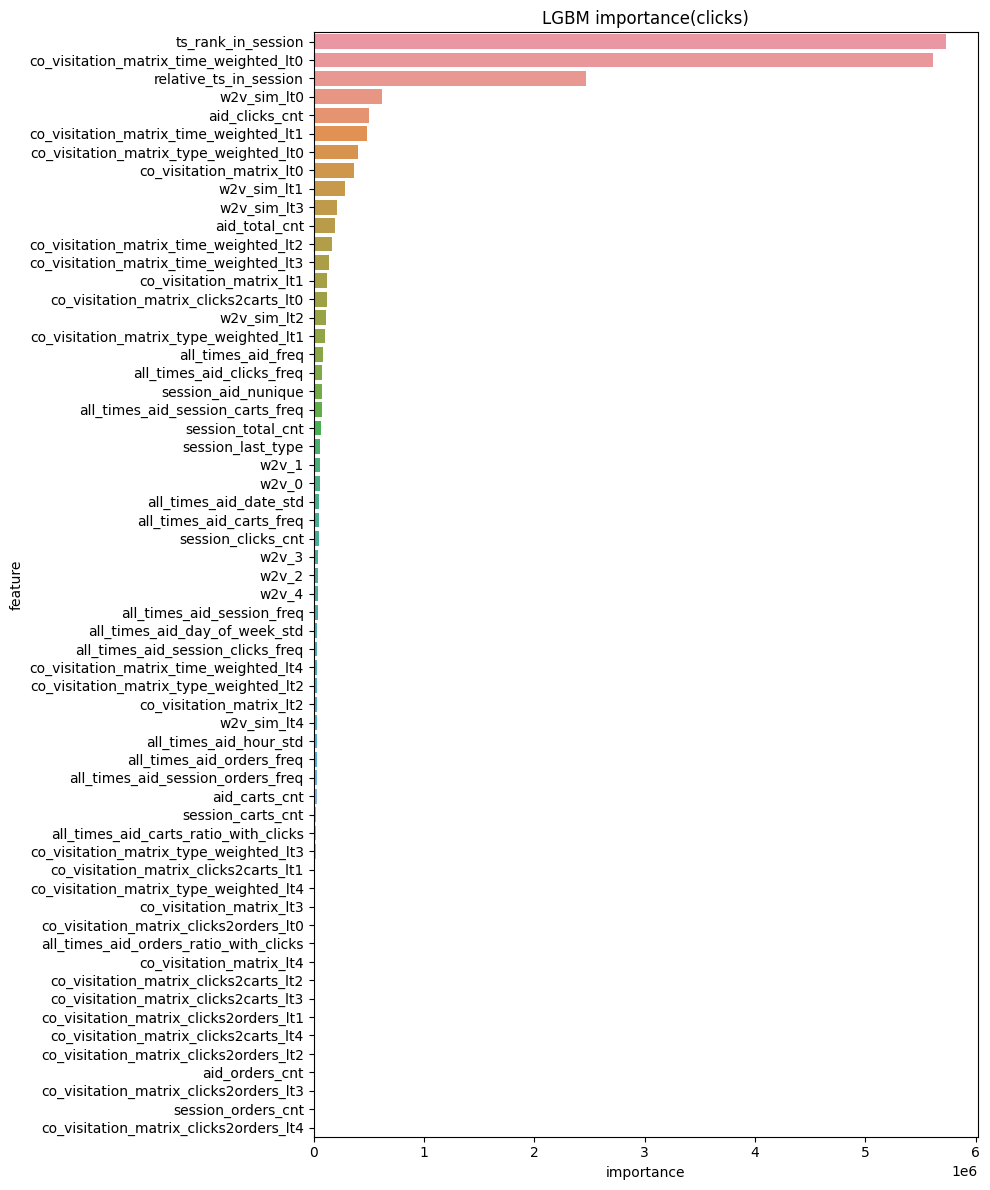

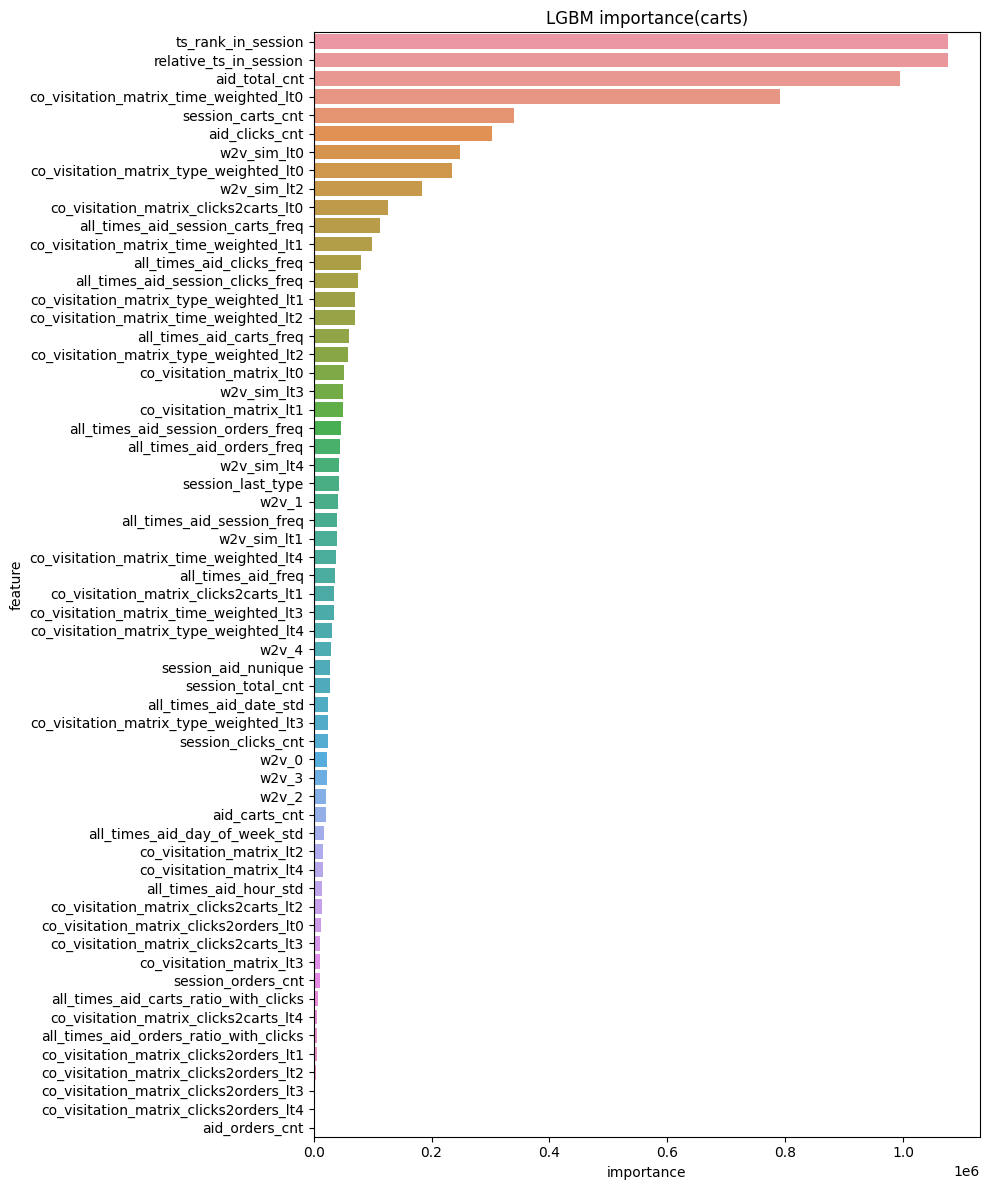

In [21]:
try:
    main()
except Exception as e:
    logger.error(traceback.format_exc())
    line_notify.send(f"{cfg.exp_name} | ERROR!!\n{traceback.format_exc()}")